# 11.3b: Black Hole Contact Analysis

**Question:** Are the 4 final black holes from 11.2c touching?

## Background

11.2c produced 4 black holes containing all 51 dead tokens. If these black holes are:
- **Touching** (pairwise L∞ ≤ 2ε): They form a quantized lattice structure
- **Separated** (L∞ >> ε): They're distinct clusters that drifted apart during training

We also want to check if distances follow powers of 2: L∞ = 2ⁿε (natural lattice spacing in binary quantization).

## Analysis Plan

1. Load final embeddings from 11.2c
2. Identify the 4 unique black hole vectors
3. Compute all pairwise L∞ (Chebyshev) distances
4. Check if distances are ≤ 2ε (touching criterion)
5. Look for powers-of-2 pattern in distances

## Parameters

In [1]:
# Data from 11.2c
EMBEDDING_PATH = "../data/embeddings_128vocab_primordial_snowball/embedding_evolution.safetensors"

# Corpus to identify dead tokens
CORPUS_PATH = "../data/training_corpus.txt"
VOCAB_SIZE = 128

# Expected noise scale from 11.2c
EPSILON = 3e-5

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from collections import Counter

## Load Embedding History

In [3]:
print(f"Loading embedding history from {EMBEDDING_PATH}...\n")

data = load_file(EMBEDDING_PATH)
embedding_history = data['embedding_history']  # [steps, vocab, dim]

num_steps, vocab_size, hidden_dim = embedding_history.shape

print(f"✓ Loaded embedding history")
print(f"  Steps: {num_steps:,}")
print(f"  Vocabulary: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading embedding history from ../data/embeddings_128vocab_primordial_snowball/embedding_evolution.safetensors...

✓ Loaded embedding history
  Steps: 10,001
  Vocabulary: 128
  Hidden dim: 64


## Identify Dead Tokens

In [4]:
print(f"\nIdentifying dead tokens...\n")

# Load corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = [b for b in corpus_text.encode('ascii') if b < VOCAB_SIZE]
alive_tokens = set(corpus_bytes)
dead_tokens = sorted([t for t in range(VOCAB_SIZE) if t not in alive_tokens])

print(f"✓ Dead tokens identified")
print(f"  Alive: {len(alive_tokens)}")
print(f"  Dead: {len(dead_tokens)}")


Identifying dead tokens...

✓ Dead tokens identified
  Alive: 77
  Dead: 51


## Extract Final Embeddings and Identify Black Holes

In [5]:
# Get final embeddings
final_embeddings = embedding_history[-1].to(torch.float32)

# Extract dead token embeddings
dead_embeddings = final_embeddings[dead_tokens]

print(f"\nAnalyzing dead token embeddings...\n")

# Find unique vectors among dead tokens
unique_dead, inverse_indices, counts = torch.unique(
    dead_embeddings,
    dim=0,
    return_inverse=True,
    return_counts=True
)

# Identify black holes (vectors with count ≥ 2)
black_hole_mask = counts >= 2
black_hole_vectors = unique_dead[black_hole_mask]
black_hole_counts = counts[black_hole_mask]

n_black_holes = len(black_hole_vectors)
total_bh_population = black_hole_counts.sum().item()

print(f"✓ Black holes identified")
print(f"  Black hole count: {n_black_holes}")
print(f"  Total black hole population: {total_bh_population}")
print(f"  Dead tokens: {len(dead_tokens)}")
print(f"\nBlack hole populations:")
for i, count in enumerate(black_hole_counts, 1):
    print(f"  BH #{i}: {count} tokens")


Analyzing dead token embeddings...

✓ Black holes identified
  Black hole count: 2
  Total black hole population: 51
  Dead tokens: 51

Black hole populations:
  BH #1: 49 tokens
  BH #2: 2 tokens


## Compute Pairwise L∞ Distances Between Black Holes

In [6]:
print(f"\nComputing pairwise L∞ distances between {n_black_holes} black holes...\n")

# Compute pairwise differences
v1 = black_hole_vectors.unsqueeze(1)  # [n, 1, d]
v2 = black_hole_vectors.unsqueeze(0)  # [1, n, d]
diffs = v1 - v2  # [n, n, d]

# L∞ distance = max absolute component difference
l_inf_distances = torch.abs(diffs).max(dim=2)[0]  # [n, n]

print(f"Pairwise L∞ distance matrix:\n")
print(f"{'':>10s}", end="")
for i in range(n_black_holes):
    print(f"BH{i+1:>2d}        ", end="")
print()

for i in range(n_black_holes):
    print(f"BH{i+1:>2d}     ", end="")
    for j in range(n_black_holes):
        dist = l_inf_distances[i, j].item()
        if i == j:
            print(f"{'—':>12s}", end="")
        else:
            print(f"{dist:>12.6e}", end="")
    print()

# Extract non-diagonal distances
mask = ~torch.eye(n_black_holes, dtype=torch.bool)
l_inf_nondiag = l_inf_distances[mask]

print(f"\nSummary statistics:")
print(f"  Min: {l_inf_nondiag.min().item():.6e}")
print(f"  Max: {l_inf_nondiag.max().item():.6e}")
print(f"  Mean: {l_inf_nondiag.mean().item():.6e}")
print(f"  Median: {l_inf_nondiag.median().item():.6e}")


Computing pairwise L∞ distances between 2 black holes...

Pairwise L∞ distance matrix:

          BH 1        BH 2        
BH 1                —9.765625e-04
BH 2     9.765625e-04           —

Summary statistics:
  Min: 9.765625e-04
  Max: 9.765625e-04
  Mean: 9.765625e-04
  Median: 9.765625e-04


## Touching Criterion

In [7]:
print(f"\n{'='*80}")
print(f"TOUCHING ANALYSIS")
print(f"{'='*80}")
print(f"Reference scales:")
print(f"  ε (bfloat16 ULP): {EPSILON:.2e}")
print(f"  2ε (touching threshold): {2*EPSILON:.2e}")
print(f"\nDistance to ε ratio:")

for i in range(n_black_holes):
    for j in range(i+1, n_black_holes):
        dist = l_inf_distances[i, j].item()
        ratio = dist / EPSILON
        touching = "✓ touching" if dist <= 2*EPSILON else "✗ separated"
        print(f"  BH{i+1} ↔ BH{j+1}: {dist:.6e} ({ratio:6.2f}× ε) {touching}")

# Count touching pairs
touching_pairs = (l_inf_nondiag <= 2*EPSILON).sum().item()
total_pairs = len(l_inf_nondiag)

print(f"\nTouching pairs: {touching_pairs} / {total_pairs}")
print(f"{'='*80}")


TOUCHING ANALYSIS
Reference scales:
  ε (bfloat16 ULP): 3.00e-05
  2ε (touching threshold): 6.00e-05

Distance to ε ratio:
  BH1 ↔ BH2: 9.765625e-04 ( 32.55× ε) ✗ separated

Touching pairs: 0 / 2


## Powers-of-2 Pattern Analysis

In [8]:
print(f"\n{'='*80}")
print(f"POWERS-OF-2 ANALYSIS")
print(f"{'='*80}")
print(f"Checking if distances follow pattern: L∞ = 2ⁿ × ε\n")

for i in range(n_black_holes):
    for j in range(i+1, n_black_holes):
        dist = l_inf_distances[i, j].item()
        ratio = dist / EPSILON
        
        # Find nearest power of 2
        log2_ratio = np.log2(ratio)
        nearest_n = round(log2_ratio)
        nearest_power = 2**nearest_n
        error = abs(ratio - nearest_power) / nearest_power * 100
        
        match = "✓" if error < 10 else "✗"
        print(f"  BH{i+1} ↔ BH{j+1}: {ratio:6.2f}× ε  ≈ 2^{nearest_n:.1f} × ε  (error: {error:5.1f}%) {match}")

print(f"{'='*80}")


POWERS-OF-2 ANALYSIS
Checking if distances follow pattern: L∞ = 2ⁿ × ε

  BH1 ↔ BH2:  32.55× ε  ≈ 2^5.0 × ε  (error:   1.7%) ✓


## Visualization: Distance Matrix Heatmap

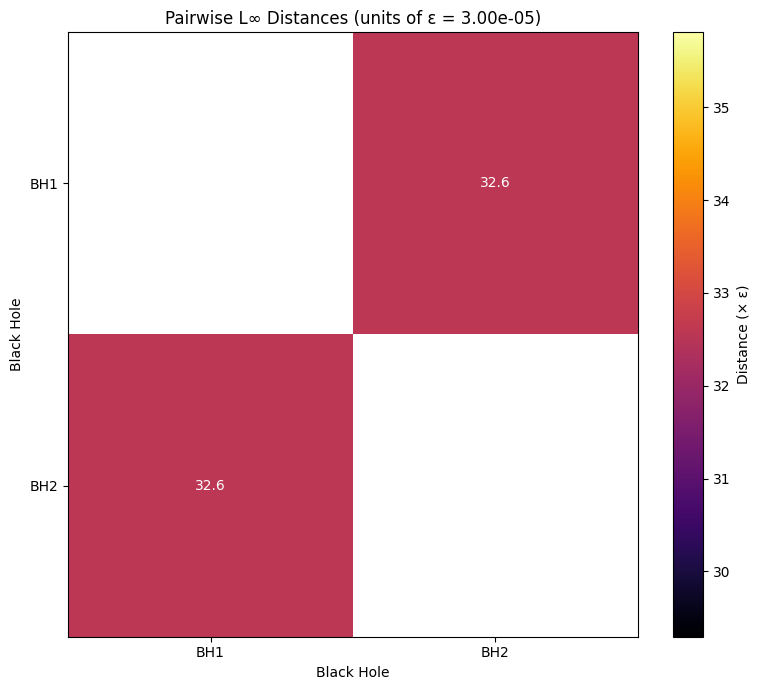

In [9]:
import matplotlib.pyplot as plt

# Create distance matrix with ε normalization
dist_matrix_normalized = (l_inf_distances / EPSILON).numpy()

# Mask diagonal for visualization
dist_matrix_normalized = np.where(np.eye(n_black_holes), np.nan, dist_matrix_normalized)

fig, ax = plt.subplots(figsize=(8, 7), dpi=100)

im = ax.imshow(dist_matrix_normalized, cmap='inferno', aspect='auto')
ax.set_xticks(range(n_black_holes))
ax.set_yticks(range(n_black_holes))
ax.set_xticklabels([f"BH{i+1}" for i in range(n_black_holes)])
ax.set_yticklabels([f"BH{i+1}" for i in range(n_black_holes)])
ax.set_xlabel("Black Hole")
ax.set_ylabel("Black Hole")
ax.set_title(f"Pairwise L∞ Distances (units of ε = {EPSILON:.2e})")

# Add text annotations
for i in range(n_black_holes):
    for j in range(n_black_holes):
        if i != j:
            text = ax.text(j, i, f"{dist_matrix_normalized[i, j]:.1f}",
                          ha="center", va="center", color="white", fontsize=10)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Distance (× ε)")

plt.tight_layout()
plt.show()

## Summary

In [10]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"Black holes analyzed: {n_black_holes}")
print(f"Total dead tokens: {len(dead_tokens)}")
print(f"Black hole population: {total_bh_population}")
print(f"\nGeometric structure:")
print(f"  Min L∞: {l_inf_nondiag.min().item():.6e} ({l_inf_nondiag.min().item()/EPSILON:.2f}× ε)")
print(f"  Max L∞: {l_inf_nondiag.max().item():.6e} ({l_inf_nondiag.max().item()/EPSILON:.2f}× ε)")
print(f"  Touching pairs: {touching_pairs}/{total_pairs}")
print(f"\nConclusion:")

if touching_pairs == total_pairs:
    print(f"  ✓ ALL black holes are touching (form connected lattice)")
    print(f"  → Matches Qwen's quantized snowball structure")
elif touching_pairs > 0:
    print(f"  ⚠ PARTIAL touching ({touching_pairs}/{total_pairs} pairs)")
    print(f"  → Some black holes connected, others separated")
else:
    print(f"  ✗ NO touching pairs (all separated by > 2ε)")
    print(f"  → Black holes drifted apart during training")

# Check if distances are approximately powers of 2
all_ratios = []
for i in range(n_black_holes):
    for j in range(i+1, n_black_holes):
        ratio = l_inf_distances[i, j].item() / EPSILON
        log2_ratio = np.log2(ratio)
        nearest_n = round(log2_ratio)
        nearest_power = 2**nearest_n
        error = abs(ratio - nearest_power) / nearest_power * 100
        all_ratios.append((ratio, nearest_power, error))

avg_error = np.mean([e for _, _, e in all_ratios])
if avg_error < 10:
    print(f"\n  ✓ Distances follow powers-of-2 pattern (avg error: {avg_error:.1f}%)")
    print(f"  → Suggests binary quantization lattice structure")
else:
    print(f"\n  ✗ Distances do NOT follow clean powers-of-2 (avg error: {avg_error:.1f}%)")
    
print(f"{'='*80}")


SUMMARY
Black holes analyzed: 2
Total dead tokens: 51
Black hole population: 51

Geometric structure:
  Min L∞: 9.765625e-04 (32.55× ε)
  Max L∞: 9.765625e-04 (32.55× ε)
  Touching pairs: 0/2

Conclusion:
  ✗ NO touching pairs (all separated by > 2ε)
  → Black holes drifted apart during training

  ✓ Distances follow powers-of-2 pattern (avg error: 1.7%)
  → Suggests binary quantization lattice structure
